In [19]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torch.optim import Adam
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import imageio

In [2]:
# Image Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),        # Resize to resnet input size
    transforms.ToTensor(),                # Convert to tensor
    transforms.Normalize(                 # Normalize using ImageNet mean/std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [3]:
data_path = "dataset/"

dataset = datasets.ImageFolder(root=data_path, transform=transform)

class_names = dataset.classes
print("Classes found:", class_names)


Classes found: ['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson']


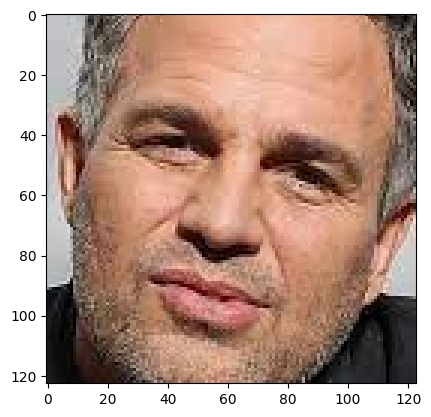

In [38]:
img_path = "mark_ruffalo/mark_ruffalo{i}.png"

for i in range(1, 10):
    plt.imshow(Image.open(data_path + img_path.format(i=i)))

In [4]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_data, test_data = random_split(dataset, [train_size, test_size])


In [5]:
batch_size = 16

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Replace final layer for 5 Avengers
model.fc = nn.Linear(model.fc.in_features, len(class_names))

model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/petpooja-1009/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:07<00:00, 6.41MB/s]


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)


In [8]:
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}" )


Epoch [1/10], Loss: 1.0550
Epoch [2/10], Loss: 0.1414
Epoch [3/10], Loss: 0.0348
Epoch [4/10], Loss: 0.0254
Epoch [5/10], Loss: 0.0099
Epoch [6/10], Loss: 0.0108
Epoch [7/10], Loss: 0.0124
Epoch [8/10], Loss: 0.0107
Epoch [9/10], Loss: 0.0064
Epoch [10/10], Loss: 0.0062


In [9]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"\nTest Accuracy: {accuracy:.2f}%")



Test Accuracy: 92.73%


mark_ruffalo


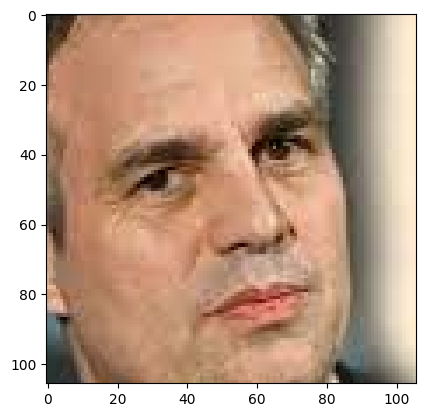

In [16]:
from PIL import Image
import matplotlib.pyplot as plt

def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        _, prediction = torch.max(outputs, 1)

    return class_names[prediction.item()]

# Example usage:
plt.imshow(Image.open("dataset/mark_ruffalo/mark_ruffalo2.png"))  # Replace with your test image path
print(predict_image("dataset/mark_ruffalo/mark_ruffalo2.png"))  # Replace with your test image path
